In [1]:
# To access the MySQL server, for data acquisition
import os 
from env import get_db_url

# Bare necessities 
import pandas as pd 
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
import scipy
from scipy import stats

# Clustering necessities
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing, cluster


# Modeling Methodology
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# Personal Effects 
import wrangle as w
import explorer as eda
import mitosheet
import folium
from folium.plugins import FastMarkerCluster
from describe import nulls
import branca.colormap as cm

# Zestimating SoCal Single Family Property Values
                                    Nicholas Dougherty
                                    March 30th, 2022
## Executive Summary

The goal has been to extrapolate a home's assessed value based on publicly available tax records contained in Zillow's data dated in 2017, preprocessing and parsing among single family residences in order to create supervised Machine Learning models. 

### Project Overview

- The DS pipeline's first-half--__acquisition, preparation, exploration__--were automated via Python scripts.
- Data cleaned by replacing null values, dropping duplicates, one-hot encoding categoricals and removing outliers.
- Data split into train, validate, and test before exploration to maintain informational integrity.
- Statistical analyses tested the following hypotheses:
    - Property Age has more considerable impact on tax value than anticipated.
    - Older homes have fewer rooms altogether and are inexpensive, half-bathrooms are found primarily in properties past the 60s. 
    - This would mean that Los Angeles wholistically, although overrepresented in this set, has outdated homes.   
- Recursive feature engineering faciliated the inclusions of features for the models 
- Since our target variable, tax value, is continuous, the following algorithms were implemented:
    - OLS Regression
    - Lasso + Lars
    - Tweedie Regressor GLM
    - Poynomial Regression. 
- The best model was fit upon the test set. Perhaps overfit, as it performs almost identically as well as the test set did. 

### Key Takeaways

- Age, bathrooms, and area were found to be the best drivers of tax value
- Outliers in room counts and area remained after handling outliers and scaling. Although in far lesser quantities. 
- The baseline mean's RMSE of $247,383.70
    - All models beat this RMSE 
- The Root Mean Squared Error (RMSE) and R squared were utilized as metrics to evaluate a model's performance
- In truth, I don't know whether or not I am looking at this correctly. I have accidentally tested twice, so it's either Tweedie or Polynomial that is the better model, but it's difficult for me to understand which. 
    
    
***
***

## Acquisition

Zillow's data was acquired from Codeup's database using the following SQL query:

                             SELECT
                                prop.*,
                                predictions_2017.logerror,
                                predictions_2017.transactiondate,
                                air.airconditioningdesc,
                                arch.architecturalstyledesc,
                                build.buildingclassdesc,
                                heat.heatingorsystemdesc,
                                landuse.propertylandusedesc,
                                story.storydesc,
                                construct.typeconstructiondesc
                            FROM properties_2017 prop
                            JOIN (
                                SELECT parcelid, MAX(transactiondate) AS max_transactiondate
                                FROM predictions_2017
                                GROUP BY parcelid
                            ) pred USING(parcelid)
                            JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                                                  AND pred.max_transactiondate = predictions_2017.transactiondate
                            LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
                            LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
                            LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
                            LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
                            LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
                            LEFT JOIN storytype story USING (storytypeid)
                            LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
                            WHERE prop.latitude IS NOT NULL
                              AND prop.longitude IS NOT NULL
                              AND transactiondate <= '2017-12-31';             
This query was read-in and processed via pandas.read_sql() function, which also requires a second positional argument other than the query; that being a connection to a MySQL database. This was done using user-specific credentials, but if you have a passcode or key of your own
use a User-Defined Function (UDF) along these lines:

        def get_db_url(database, username=username, host=host, password=password):
            return f"mysql+pymysql://{username}:{password}@{host}/{database}"
    
Just set strings in the .py file containing the appropriate kwarg values. 
Copy my method of creating a csv of this dataframe, and read from it in the future, as the acquisition is otherwise computationally and chronistically exhaustive. Save yourself the time. 

You're tapped into the data, and quickly you'll see that it's problematic from the onset. 
****
****

In [2]:
# Note, that w here is being used as an alias from the wrangle.py this function was imported from in the first cell.
df = w.acquire_zillow_data()
print(f"This shape {df.shape} won't last long, and here's why:")

Using cached CSV
This shape (77380, 68) won't last long, and here's why:


In [3]:
print('Nearly half of the data is Null \n\n')
nulls(df)

Nearly half of the data is Null 


Null Values by Column: 
                              count  percentage
buildingclassdesc             77365       99.98
buildingclasstypeid           77365       99.98
finishedsquarefeet13          77339       99.95
storytypeid                   77330       99.94
basementsqft                  77330       99.94
storydesc                     77330       99.94
yardbuildingsqft26            77310       99.91
fireplaceflag                 77208       99.78
architecturalstyletypeid      77174       99.73
architecturalstyledesc        77174       99.73
typeconstructiondesc          77158       99.71
typeconstructiontypeid        77158       99.71
finishedsquarefeet6           76994       99.50
pooltypeid10                  76916       99.40
decktypeid                    76766       99.21
poolsizesum                   76513       98.88
pooltypeid2                   76306       98.61
hashottuborspa                75842       98.01
yardbuildingsqft17           

## Preparation
The first solving approach taken for this problem is setting a threshold along columns and rows. 50% was set for each. Thirty-four columns were lost in the process (R.I.P.). You'll see this revealed by the upcoming UDF, as it prints out the columns lost based on the threshold. Print statements will indicate steps beyond that point, all the way to the cleaned dataframe being returned to its requester.

In [4]:
df = w.prep_zillow_og(df)
df.shape

Beginning preparation...

Detecting Nulls; set to delete columns and then rows are comprised of 50% nulls

    The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Selecting propertylanduse by the poten

(32204, 22)

*** 
***
## Exploratory Data Analysis

"HEY, wait a minute! You haven't shown me any univariate relationships or distributions! AND you haven't split your data!" - Fluster(at)ed Imaginary Zillow Employee Who Will Probably be one of the 25% of staff dropped in 2020. (We're pretending it's 2017. I wish.)

Now, now, now. I was just demonstrating the prepare function. I actually have a wrangle function that will return the splits: train, validate, and test, as well as the X_train, y_train, X_validate, y_....you get the idea. 

But since EDA doesn't need those other elements, all I need to grab here is train.

In [5]:
train = w.get_exploration_data()

Using cached CSV


In [6]:
#folium_map = eda.california(train)
#folium_map

### So on average, how large is the land that we are looking at?

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


First off, Mr. Warning Message/Error from LoZ 2, YOU'RE NOT MY REAL DAD


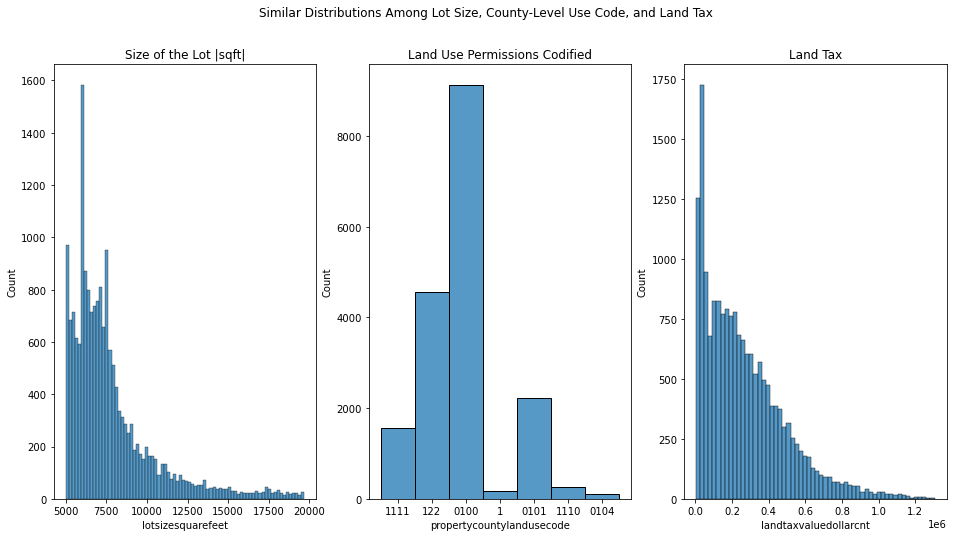

             
                                The vast majority of land is well under 1/5 of an acre
                             With a spike in low costs, and low area. 
                             
                                Each of the four-digit land use codes belong to Los Angeles,
                            hence their abundance of representation.
          
---------------------------------------------------------------    ---------------------------------------------------------------------------


In [10]:
eda.landquest(train)

### How similarly are the costs per square foot features distributed? Do the costs seem realisitic? And while looking at engineered features, was there a fiscal quarter that factored noticeably more properties? 

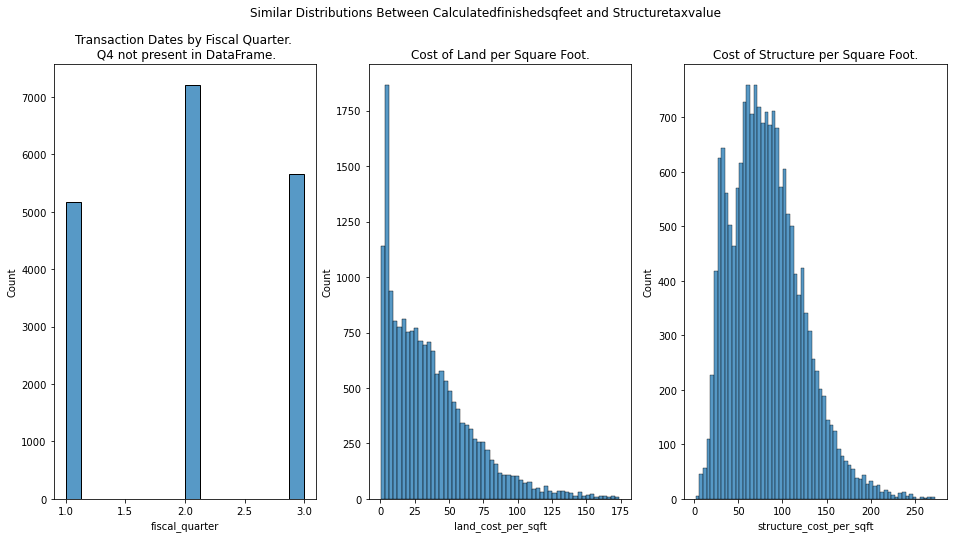


                            Unsurprisingly, structural costs per sq ft blow land costs out of the water.
                            In the current times, the median cost of a square foot of land in LA, CA, is $1.38.
                            I'll check to see if this lines up with the dataframe. Moreover, the cost 
                            to build a home ranges from $100-$400 this year, we can also check 
                            if there is consistency with 2017 by examining the margins more closely.
         
          
---------------------------------------------------------------------    ---------------------------------------------------------------------


In [16]:
eda.costpersqft(train)

In [36]:
la_bby = train[train['los_angeles'] == 1]
land_cost_median = np.median(la_bby['land_cost_per_sqft'])
land_cost_median

orange_hny = train[train['orange'] == 1]
orange_hnny_median = np.median(orange_hny['land_cost_per_sqft'])

print(f' Median value for land in Los Angeles is {round(land_cost_median,2)} per square foot')
print(f'Median value for land in Orange is {round(orange_hnny_median,2)} per square foot')

 Median value for land in Los Angeles is 26.45 per square foot
Median value for land in Orange is 41.29 per square foot


Downard trends taken from the visualization:
- tax value decreases as the property ages, particular beyond a half-decade.
- the older a property is, the smaller it tends to be. And so with age, numbers of beds and baths also decrease.

Upward trends, those that potentially drive up value:
- Unsurprisingly, as area gets larger, so too does the assessed value. Moreover, more bed, more baths, more beyond. Where beyond is the assessed value. 

#### A closer look: bringing the heat with correlation.

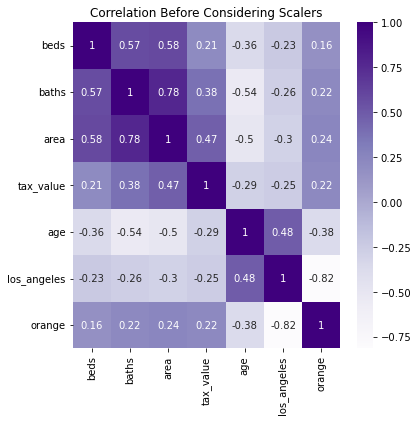

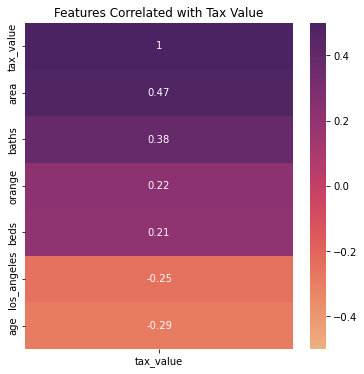

In [4]:
tax_correlations(train)

Insights:
This is in line with what has been inferred by looking at those pairplots. Area is close to having a moderate relationship, but ultimately the correlation coefficients are not high enough at present to be considered reliable. 
The surprise here is that Los Angeles is, at least from how this data has been cleaned, showing a negative correlation with tax value. And so, this suggests that costs are lower there, so perhaps the homes are older, and hence smaller, in many mapped pockets. 

### Zillow is Begging the Question(s)
Statistical ones, that is. 
Let's look more closely, starting with age and tax value. 
Here you see density contour lines indicating that the tax value is lowest among homes sixty years old or older. 
But statistically, is there any significance to this?

In [5]:
show_maps_tv_age(train)

To test this, using an alpha value of 0.01, Spearman's coefficiency test was conducted with train.age and train.tax_value. The null was that a home's value is independent of age; this was rejected, and we moved forward with the firm belief that tax value in some way depends on age, overall. 

In [6]:
test_age(train)

Having successfully rejected the null, a home's value in some way depends on its age 


### Knowing that age is worth consideration, how does it interact with area?
It is fair to assume that homes in the afforementioned mid-20th century strata would be smaller, since intuitively, as well as economically, property is worth more the larger the area. This is of course affected by its condition and attributes, but for now, let's set that aside and test if there's statistical relevancy to size in general. 

In [7]:
show_maps_age_area(train)

#### Does size really matter?
Continuing with using a confidence interval of 99%, bigger houses were made into a variable based on the median area, 1679. An independent t-test was conducted, and houses greater than or equal to 1679 square feet are in no way dependent on those less than it, so size does matter when it comes to value; and this has its own implications for age. 

In [8]:
testing_area(train)

Reject null hypothesis that: Median home value 1,679 sq ft, whether increased or decreased, is independent of assessed value.


### Speaking about area makes me feel dirty. Let's test some areas used for cleaning now, shall we?
Let's visualize baths as they relate to age, just for fun. I'm getting older, and I want to see some violins. 

In [9]:
baths_and_age(train)

### Like music to my eyes. 
Not as pleasant as auditory experiences. Bathrooms have such nice acoustics, they work well for vocal booths. 
But the sound of silence is excellent in bathrooms, too, especially in public ones. Which are becoming decreasingly unavailable or restrictive in California. 

Anyhow, note that through early exporation it became apparent that half bathrooms only appear beyond 0% in Ventura and Orange, so each of these mid points is in either Ventura or Orange county. 

With that in mind, notice how one bathroom homes have their highest representation from a half-century to a full century; many of those may be in Los Angeles. As bathrooms swell in size, drooping down like icicles, the age drops. Newer homes have more bathrooms, collectively, than old ones. 

## Let's test out these toilets. 

Spearman's correlation handles outliers better for this scenario, and more generally. Alpha stays the same, and we once again have successfully rejected the null. 

We can only go up from here, right?

                                                                           right?

In [10]:
test_baths(train)


r =  -0.58
p =  0.0

Reject H0
Thus, number of baths and age have a linear relationship.


***
***

## Preprocessing and Modeling

All is fair in love and scaling, even in a place like Southern California. 
I used a MinMax scaler here. Subsequently it was recursively feature engineered, so as to accomodate five features in hopes of optimizing our upcoming machine learning model. 

In [11]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

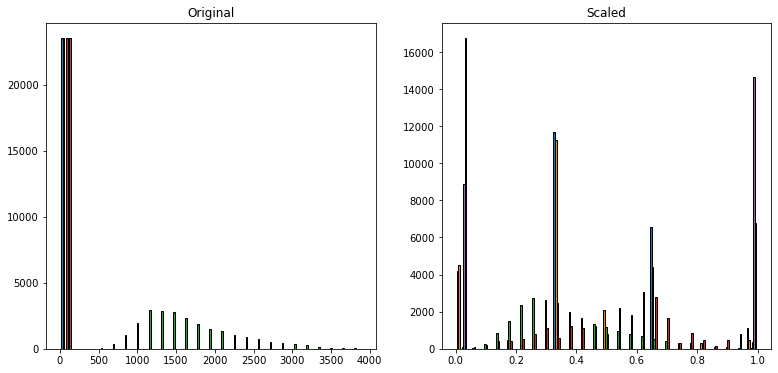

In [12]:
scaling_impact(X_train, X_train_scaled)

In [13]:
features_to_use, feature_rankings = select_rfe(X_train_scaled, y_train, 5, return_rankings=True)

In [14]:
#print(feature_rankings.sort_values())
print(' \n Use the following features: \n')
print(feature_rankings)
features = ['beds', 'baths', 'area', 'age', 'los_angeles']

 
 Use the following features: 

beds           1
baths          1
area           1
age            1
los_angeles    1
orange         2
dtype: int64


### One step at a time. 
Step One, establish a baseline. 

In [15]:
# 1. Predict mean tax value 
tv_pred_mean = y_train.tax_value.mean()
y_train['tv_pred_mean'] = tv_pred_mean
y_validate['tv_pred_mean'] = tv_pred_mean

# 2. Predict median tax value 
tv_pred_median = y_train.tax_value.median()
y_train['tv_pred_median'] = tv_pred_median
y_validate['tv_pred_median'] = tv_pred_median

# 3. RMSE of tv_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tv_pred_median
rmse_train1 = mean_squared_error(y_train.tax_value, y_train.tv_pred_median) ** .5
rmse_validate1 = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 2))

RMSE using Mean
Train/In-Sample:  244358.79 
Validate/Out-of-Sample:  247383.7
-----------
RMSE using Median
Train/In-Sample:  246614.86 
Validate/Out-of-Sample:  249653.86


### Mean and median are close contenders.
I really don't know the advantage to either, so I'll flip a coin. 
My odds are better doing that than they would be trusting assessed tax records as a significant indicator of market value. 
#### flips coin
##### it's a head
## Heads-up, we're going with mean

Let's put it into an empty data frame. 

In [16]:
# add the mean baseline to a df to help evaluate all models side by side
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_mean)}])

In [17]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.0


### OLS

In [18]:
lm = LinearRegression()
lm.fit(X_train_scaled[features], y_train.tax_value)
y_train['tv_pred_lm'] = lm.predict(X_train_scaled[features])
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm) ** (1/2)
# predict validate
y_validate['tv_pred_lm'] = lm.predict(X_validate_scaled[features])
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  211815.74555149165 
Validation/Out-of-Sample:  213948.6103911231


In [19]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'OLS lm',
    'rmse_outofsample': rmse_validate,
        'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_lm)}, ignore_index=True)

## Tweedie

In [20]:
glm = TweedieRegressor(power=0, alpha=1)
glm.fit(X_train_scaled[features], y_train.tax_value)
y_train['tv_pred_glm'] = glm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm) ** (1/2)
# predict validate
y_validate['tv_pred_glm'] = glm.predict(X_validate_scaled[features])
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_glm) ** (1/2)


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  237778.34731167604 
Validation/Out-of-Sample:  240893.92232643464


In [21]:
# add model to metric df
metric_df = metric_df.append(
    {
    'model': 'Tweedie GLM power 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_glm)}, ignore_index=True)

In [22]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.000000
1,OLS lm,213948.610391,0.252141
2,Tweedie GLM power 1,240893.922326,0.051778


## Lasso + Lars

In [23]:
lars = LassoLars(alpha=1)
lars.fit(X_train_scaled[features], y_train.tax_value)
y_train['tv_pred_lars'] = lars.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lars) ** (1/2)
# predict validate
y_validate['tv_pred_lars'] = lars.predict(X_validate_scaled[features])
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  211816.0944804274 
Validation/Out-of-Sample:  213952.88164697244


In [24]:
# add model to metric df
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_lars)}, ignore_index=True)

In [25]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.000000
1,OLS lm,213948.610391,0.252141
2,Tweedie GLM power 1,240893.922326,0.051778
3,LassoLars alpha 1,213952.881647,0.252111


## Polynomial Regression

In [26]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled features
X_train_degree3 = pf.fit_transform(X_train_scaled[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[features])
X_test_degree3 = pf.transform(X_test_scaled[features])


In [27]:
pm = LinearRegression(normalize=True)

pm.fit(X_train_degree3, y_train.tax_value)

y_train['tv_pred_pm'] = pm.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_pm) ** (1/2)

# predict validate
y_validate['tv_pred_pm'] = pm.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_pm) ** (1/2)

print("RMSE for PolynomialRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for PolynomialRegression
Training/In-Sample:  205490.94732272287 
Validation/Out-of-Sample:  208428.68930359627


In [28]:
# add model to metric df
metric_df = metric_df.append(
    {
    'model': 'PolyReg Model',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_pm)}, ignore_index=True)
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.000000
1,OLS lm,213948.610391,0.252141
2,Tweedie GLM power 1,240893.922326,0.051778
3,LassoLars alpha 1,213952.881647,0.252111
4,PolyReg Model,208428.689304,0.290149


### Tweedie is very close to estimating the baseline. This is a good sign, and makes it our best model. 
Let's test it. Put it to the test. 

                                                        compare it to test. 
Literally. Well, almost literally. 

In [29]:
# Fit best performing model on TestSplit
# predict on test
y_test['tv_pred_pm'] = pm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tv_pred_pm) ** (1/2)
print("RMSE for Model using PolynomialRegression\nOut-of-Sample Performance: ", rmse_test)

NameError: name 'X_test_degree2' is not defined

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'Test',
    'rmse_outofsample': rmse_test,
    'r^2_outofsample': explained_variance_score(y_test.tax_value, y_test.tv_pred_glm)}, ignore_index=True)

In [ ]:
metric_df

In [ ]:
print(f'Baseline Minus Validate RMSE: =')
247383.70 - 240893.92

In [ ]:
print(f'Baseline Minus Test RMSE: =') 
247383.70 - 238717.40

### Test outperforms the baseline. 
But it's also outperformed ever so slightly by validate's out of sample performance. 
At present I do not know the implications of this. But it would seem as though validate is accurate in this instance. Let's go over what this really means, at least to someone who knows little about regression at present. 

Among a sample of homes where so much money is at stake, a 200 grand difference can be cause for celebration or another step closer to financial ruin, depending on the efficacy of the model. Both underestimating and overestimating run unique risks. Overestimates can dissuade buys from even considering the home, if it is in a tax bracket and range far beyond what is reasonable to them. Underpaying can be great for purchasing homes, but as for selling, not at all. 

### At Day's End:

We were very close to estimating the home value based on how test compares to the baseline, but I don't know if I am interpreting the goal correctly. If not, Polynomial is the best pick. 
If I am correct in assessing the assessed value, use the model and let's improve upon it.
If I completely missed the point, have mercy on my soul. 

### Given more time. 

I would probably not panic as much, would better understand my role as a new zillow employee, and would probably not obsess over reading about the matters outside of the project. 

Please don't fire me. 

Regards,

Nicholas Dougherty